<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Launch Sites Locations Analysis with Folium**


Estimated time needed: **40** minutes


The launch success rate may depend on many factors such as payload mass, orbit type, and so on. It may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.


In the previous exploratory data analysis labs, you have visualized the SpaceX launch dataset using `matplotlib` and `seaborn` and discovered some preliminary correlations between the launch site and success rates. In this lab, you will be performing more interactive visual analytics using `Folium`.


## Objectives


This lab contains the following tasks:

*   **TASK 1:** Mark all launch sites on a map
*   **TASK 2:** Mark the success/failed launches for each site on the map
*   **TASK 3:** Calculate the distances between a launch site to its proximities

After completed the above tasks, you should be able to find some geographical patterns about launch sites.


Let's first import required Python packages for this lab:


In [1]:
import piplite
await piplite.install(['folium'])
await piplite.install(['pandas'])

In [2]:
import folium
import pandas as pd

In [3]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

If you need to refresh your memory about folium, you may download and refer to this previous folium lab:


[Generating Maps with Python](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module\_3/DV0101EN-3-5-1-Generating-Maps-in-Python-py-v2.0.ipynb)


In [4]:
## Task 1: Mark all launch sites on a map


First, let's try to add each site's location on a map using site's latitude and longitude coordinates


The following dataset with the name `spacex_launch_geo.csv` is an augmented dataset with latitude and longitude added for each site.


In [5]:
# Download and read the `spacex_launch_geo.csv`
from js import fetch
import io

URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv'
resp = await fetch(URL)
spacex_csv_file = io.BytesIO((await resp.arrayBuffer()).to_py())
spacex_df=pd.read_csv(spacex_csv_file)
spacex_df.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


Now, you can take a look at what are the coordinates for each site.


In [6]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.


We first need to create a folium `Map` object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.


In [11]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We could use `folium.Circle` to add a highlighted circle area with a text label on a specific coordinate. For example,


In [12]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

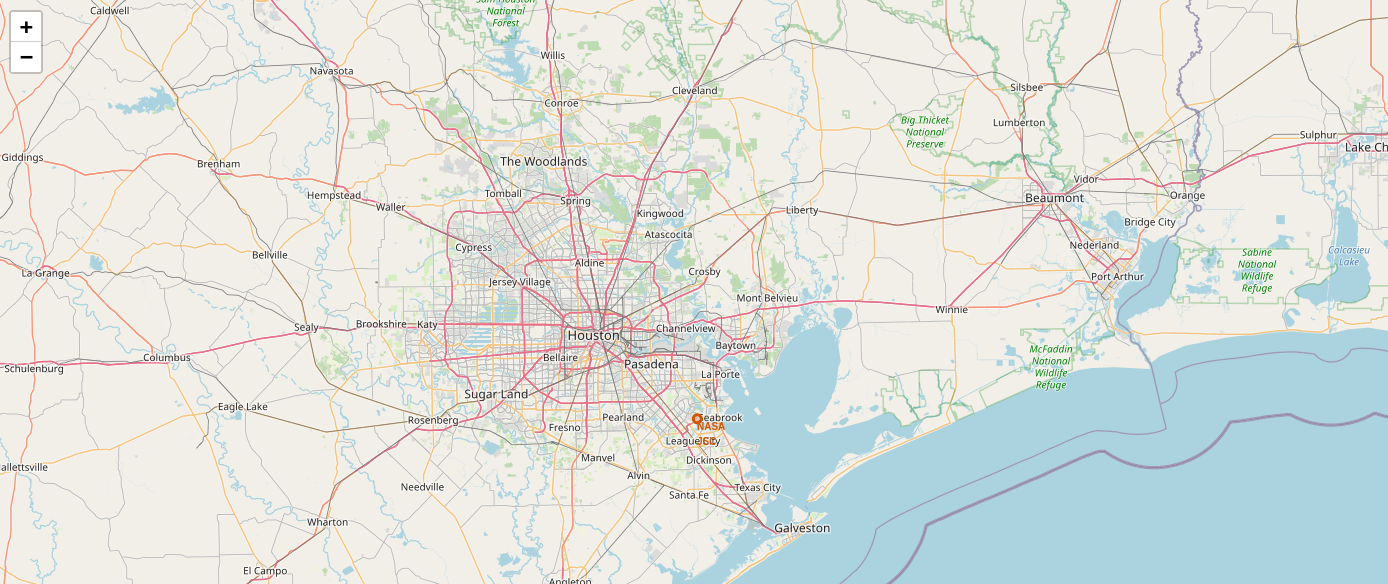

and you should find a small yellow circle near the city of Houston and you can zoom-in to see a larger circle.


Now, let's add a circle for each launch site in data frame `launch_sites`


*TODO:*  Create and add `folium.Circle` and `folium.Marker` for each launch site on the site map


An example of folium.Circle:


`folium.Circle(coordinate, radius=1000, color='#000000', fill=True).add_child(folium.Popup(...))`


An example of folium.Marker:


`folium.map.Marker(coordinate, icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'label', ))`


In [14]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for launch_site, lat_site, long_site in zip(launch_sites_df['Launch Site'], launch_sites_df['Lat'], launch_sites_df['Long']):
    #print(launch_site, lat_site, long_site)
    site_coord=[lat_site, long_site]
    circle = folium.Circle(site_coord, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(launch_site))
    
    marker = folium.map.Marker(
    site_coord,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % launch_site,
        )
    )
    site_map.add_child(circle)
    site_map.add_child(marker)
    
site_map    
    
    
    
    
    
    
    
    

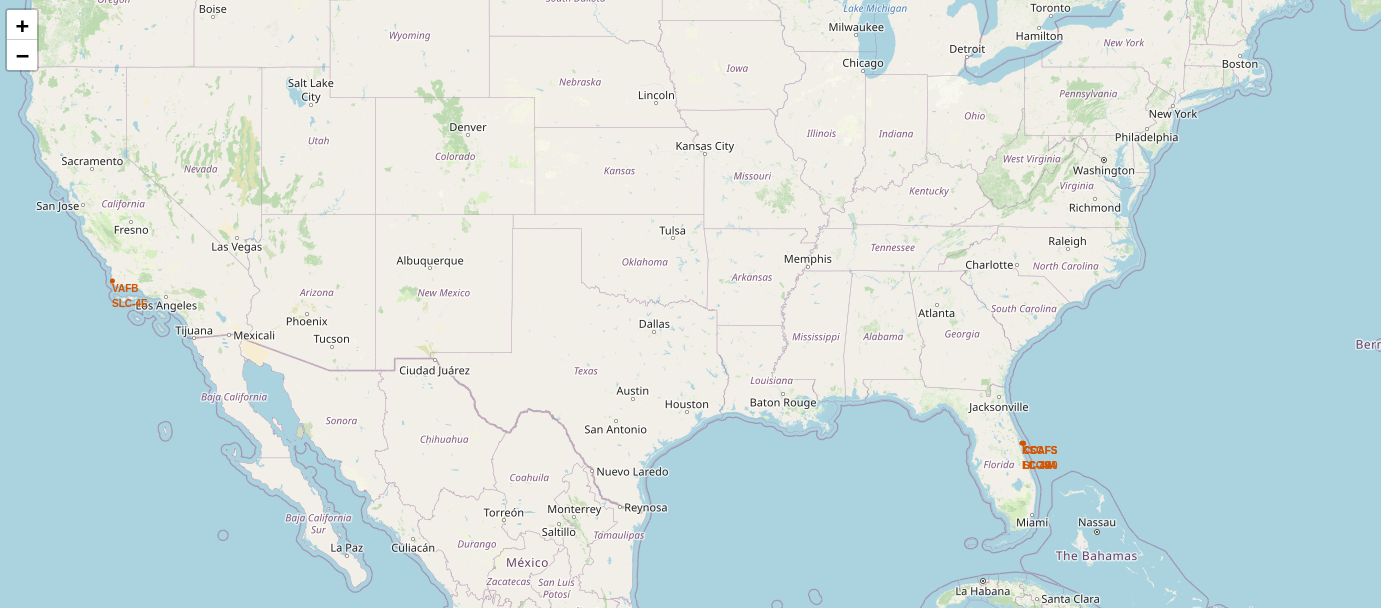

In [15]:
launch_sites_df.head()

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


The generated map with marked launch sites should look similar to the following:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_markers.png">
</center>


Now, you can explore the map by zoom-in/out the marked areas
, and try to answer the following questions:

*   Are all launch sites in proximity to the Equator line?
*   Are all launch sites in very close proximity to the coast?

Also please try to explain your findings.


In [16]:
# Task 2: Mark the success/failed launches for each site on the map


Next, let's try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates.
Recall that data frame spacex_df has detailed launch records, and the `class` column indicates if this launch was successful or not


In [17]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class
46,KSC LC-39A,28.573255,-80.646895,1
47,KSC LC-39A,28.573255,-80.646895,1
48,KSC LC-39A,28.573255,-80.646895,1
49,CCAFS SLC-40,28.563197,-80.576820,1
50,CCAFS SLC-40,28.563197,-80.576820,1
51,CCAFS SLC-40,28.563197,-80.576820,0
52,CCAFS SLC-40,28.563197,-80.576820,0
53,CCAFS SLC-40,28.563197,-80.576820,0
54,CCAFS SLC-40,28.563197,-80.576820,1
55,CCAFS SLC-40,28.563197,-80.576820,0


Next, let's create markers for all launch records.
If a launch was successful `(class=1)`, then we use a green marker and if a launch was failed, we use a red marker `(class=0)`


Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.


Let's first create a `MarkerCluster` object


In [18]:
marker_cluster = MarkerCluster()


*TODO:* Create a new column in `launch_sites` dataframe called `marker_color` to store the marker colors based on the `class` value


In [19]:

# Apply a function to check the value of `class` column
# If class=1, marker_color value will be green
# If class=0, marker_color value will be red
#import numpy as np
#spacex_df['marker_color'] = np.where(spacex_df['class']==1, 'green', 'red')
#spacex_df.tail(10)

def assign_marker_color(Outcome):
    if Outcome==1:
        return 'green'
    else:
        return 'red'
    
   
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


*TODO:* For each launch result in `spacex_df` data frame, add a `folium.Marker` to `marker_cluster`


In [21]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    launch_site=record['Launch Site']
    lat_site=record['Lat']
    long_site=record['Long']
    site_coord=[lat_site, long_site]
    # TODO: Create and add a Marker cluster to the site map
    marker = folium.map.Marker(site_coord, icon=folium.Icon(color='white', icon_color=record['marker_color'], icon_anchor=(0,0), html='%s'%launch_site,))
    marker_cluster.add_child(marker)

site_map

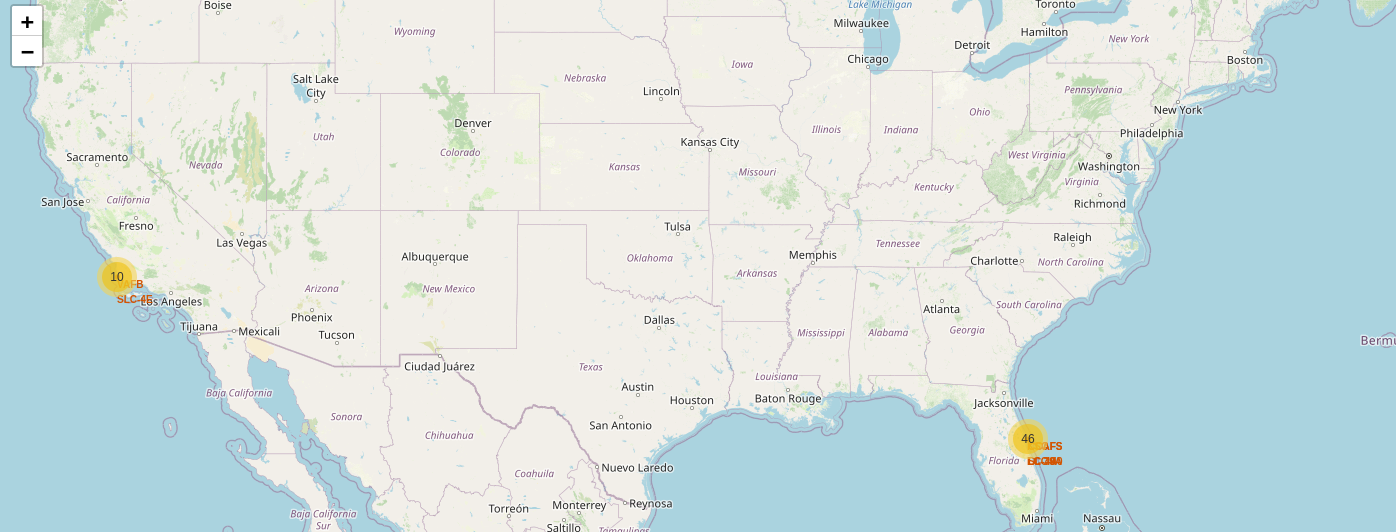

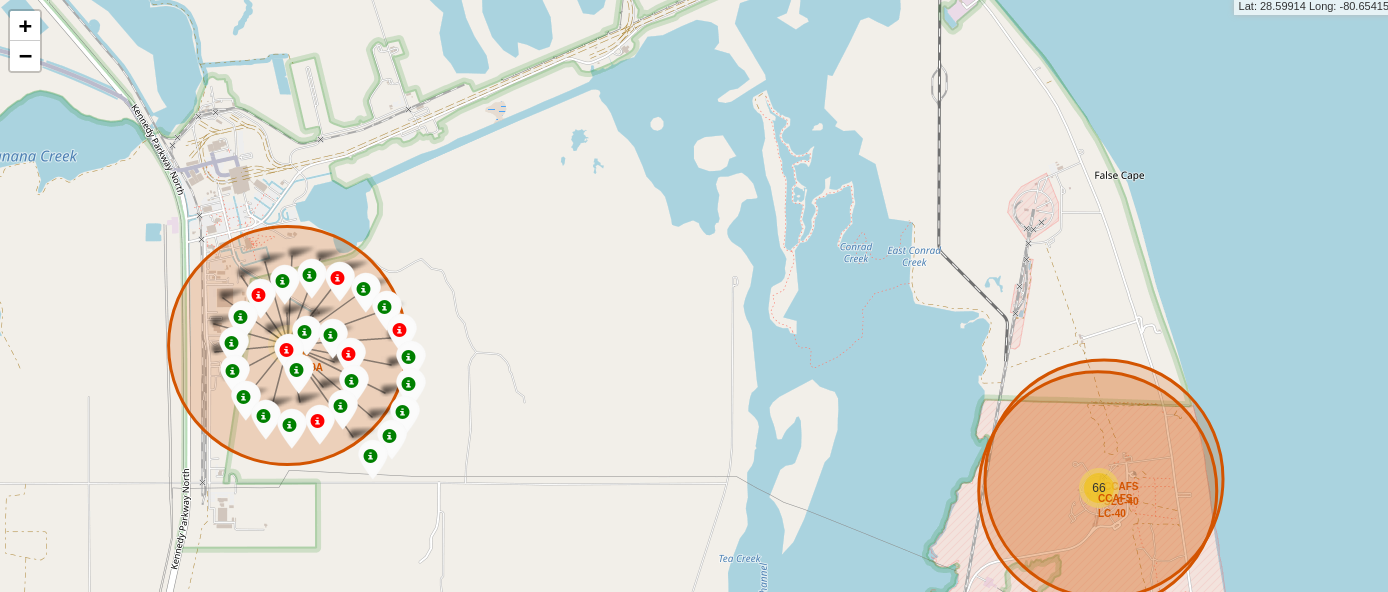

Your updated map may look like the following screenshots:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_cluster.png">
</center>


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_cluster_zoomed.png">
</center>


From the color-labeled markers in marker clusters, you should be able to easily identify which launch sites have relatively high success rates.


In [26]:
# TASK 3: Calculate the distances between a launch site to its proximities


Next, we need to explore and analyze the proximities of launch sites.


Let's first add a `MousePosition` on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)


In [28]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.


Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.


In [29]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

*TODO:* Mark down a point on the closest coastline using MousePosition and calculate the distance between the coastline point and the launch site.


In [30]:
# find coordinate of the closet coastline
# e.g.,: Lat: 28.56367  Lon: -80.57163
# distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
coastline_lat=28.56391
coastline_lon=-80.56779
launch_site_lat=28.56344
launch_site_lon=-80.57676
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
distance_coastline



0.8778520022693409

In [36]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
# for example
coordinate=[coastline_lat, coastline_lon]
distance_marker = folium.Marker(
    coordinate,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
        )
    )
site_map.add_child(distance_marker)
site_map

*TODO:* Draw a `PolyLine` between a launch site to the selected coastline point


In [35]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
coordinates=[[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]]
lines=folium.PolyLine(locations=coordinates, weight=1)
#site_map.add_child(lines)

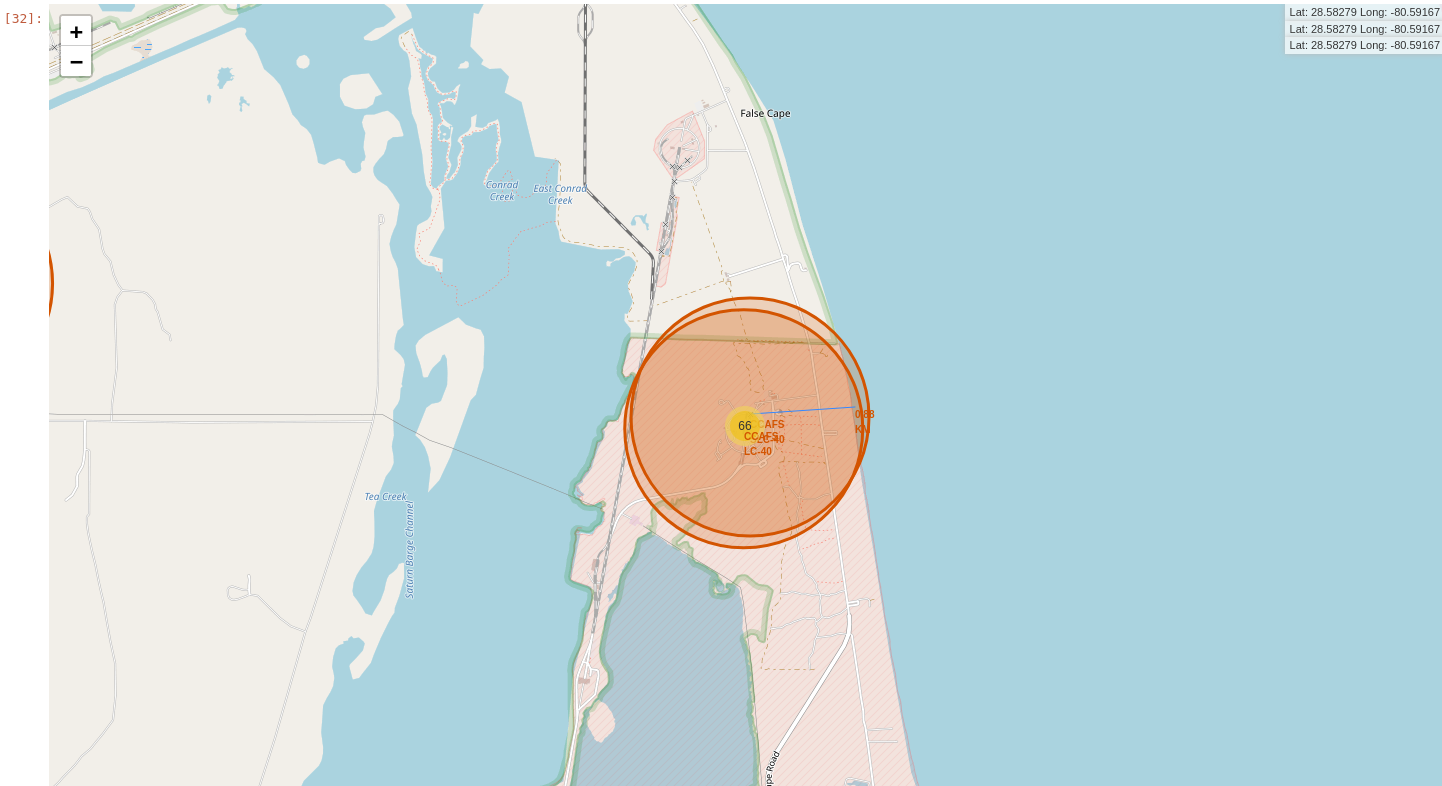

Your updated map with distance line should look like the following screenshot:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_distance.png">
</center>


*TODO:* Similarly, you can draw a line betwee a launch site to its closest city, railway, highway, etc. You need to use `MousePosition` to find the their coordinates on the map first


A railway map symbol may look like this:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/railway.png">
</center>


A highway map symbol may look like this:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/highway.png">
</center>


A city map symbol may look like this:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/city.png">
</center>


In [34]:
# Create a marker with distance to a closest city, railway, highway, etc.
# Draw a line between the marker to the launch site
rail_coord=[28.57236,-80.58525]
highway_coord=[28.5636, -80.57082]
city_coord=[28.24088,-80.72891]

launch_site_coord=[launch_site_lat, launch_site_lon]
distance_rail = calculate_distance(launch_site_coord[0], launch_site_coord[1], rail_coord[0], rail_coord[1])
distance_highway = calculate_distance(launch_site_coord[0], launch_site_coord[1], highway_coord[0], highway_coord[1])
distance_city = calculate_distance(launch_site_coord[0], launch_site_coord[1], city_coord[0], city_coord[1])

for coordinate, distance in zip([rail_coord, highway_coord, city_coord], [distance_rail, distance_highway, distance_city]):
    distance_marker = folium.Marker(
        coordinate,
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance),
        )
    )
    site_map.add_child(distance_marker)
    lines=folium.PolyLine([launch_site_coord, coordinate], weight=1)
    site_map.add_child(lines)
    
site_map

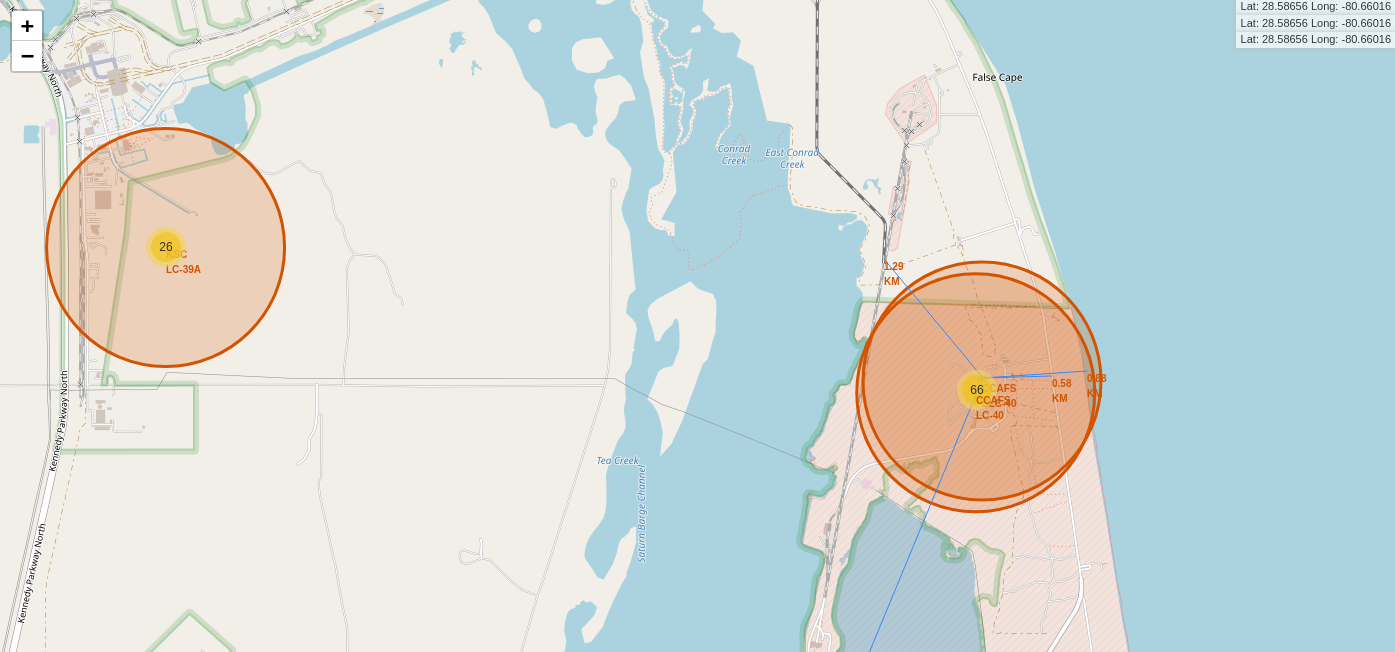

After you plot distance lines to the proximities, you can answer the following questions easily:

*   Are launch sites in close proximity to railways?
*   Are launch sites in close proximity to highways?
*   Are launch sites in close proximity to coastline?
*   Do launch sites keep certain distance away from cities?

Also please try to explain your findings.


# Next Steps:

Now you have discovered many interesting insights related to the launch sites' location using folium, in a very interactive way. Next, you will need to build a dashboard using Ploty Dash on detailed launch records.


## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2022-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
